In [7]:
import numpy as np
import pandas as pd
import scipy 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

When confronted with data that has discrete categories, it is often valuable to consider the problem in which one must sort unseen data into these categories based on some set of attributes common to both the old data and the new, unsorted data. This is formally referred to as a classification problem in machine learning. 

One solution to this problem is called k-Nearest Neighbors, or kNN. This is a supervised method, which means it's a useful approach when the "old" data, or training set, it already labelled. In this notebook we will explore what some clustered data might look like, as well as how to build a kNN classifier from scratch. 

The prerequisite knowledge to understanding kNN is really only geometry -- knowing the pythagorean theorem. To apply it, you should be familiar with a programming language of your choice, as well as proper data etiquette, meaning respecting the boundary between training data and the data of testing and validation.

In [384]:
numberOfSamples = 500
spread = 6

dataSeed = 10

Here we call upon Sci-kit Learn to build some blobs for us to play with. Play around with these parameters and see how your results change. Be aware that the data generating process we use here automatically creates a balanced number of classes, which will not generally be the case. You must be careful with this in application.

In [385]:
# data generation paramaterized by the inputs above. make_blobs is from sci-kit learn.

# There are items below dependent on the number of clusters.
numberOfClusters = 5

points, labels = make_blobs(n_samples=numberOfSamples,centers=numberOfClusters,
                            cluster_std=spread,random_state=dataSeed)

In [386]:
# cleaning up the generated data.
# .T is the transpose operation

data = {'x':points.T[0],
       'y':points.T[1],
       'Class':labels}

assert(sum([points[i][0] for i in range(10)] == points.T[0][:10]) == 10)

Suppose we have some data on categories and their descriptive data. 

In [387]:
clusterData = pd.DataFrame(data)
clusterData.head()

,x,y,Class
0,-13.773491,-0.634583,3
1,-6.610868,13.044917,1
2,-2.805094,-4.192714,2
3,-12.552215,10.921090,3
4,0.956953,-0.200472,1


None of these classes are particularly rare or excessively common. Our understanding of them is relatively equal.

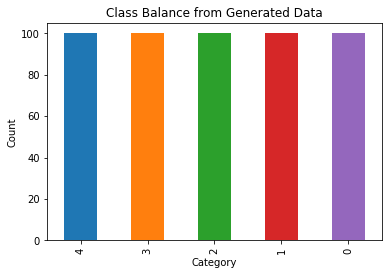

In [388]:
# verifying that the classes are balanced

clusterData['Class'].value_counts().plot(kind='bar');
plt.xlabel('Category');
plt.ylabel('Count');
plt.title('Class Balance from Generated Data');

Let's call these categories the genre of music associated with an artist. We can describe the artist's genre with data points x and y, but these sound more interesting as "Fan Intensity" and "Track Pace". 

We could add many more of these descriptive variables to narrow down the data, but the same principles apply with 2 variables. Let's proceed.

In [389]:
# Fabricating some interesting labels for our classes

classLabels = {0:'Psychedelic Rock',
            1:'Doom Metal',
            2:'Rap',
            3:'Reggae',
            4:'Drum and Bass'
            }

musicLabel = {'Class':classLabels}
newColumnNames = {'x':'Fan Intensity',
                 'y':'Track Pace',
                 'Class':'Genre'}

In [390]:
# Swapping out the old labels for the ones above.
# Feel free to create whichever categories you like

musicData = clusterData.replace(musicLabel)
musicData = musicData.rename(index=str,columns=newColumnNames)
musicData.head()

,Fan Intensity,Track Pace,Genre
0,-13.773491,-0.634583,Reggae
1,-6.610868,13.044917,Doom Metal
2,-2.805094,-4.192714,Rap
3,-12.552215,10.921090,Reggae
4,0.956953,-0.200472,Doom Metal


With this data in hand, we aim to *classify* a new datapoint that is given to us by a friend. Our friend says that this artist has -10 of Fan Intensity, and -5 of Track Pace. What genre do you think this artist is best described by?

In [391]:
unknownArtist = [-10,-5]

A natural way to approach this problem is to think about the artists we know and what genre they fall into, then decide where this unknown artist fits with respect to them and their genre classification.

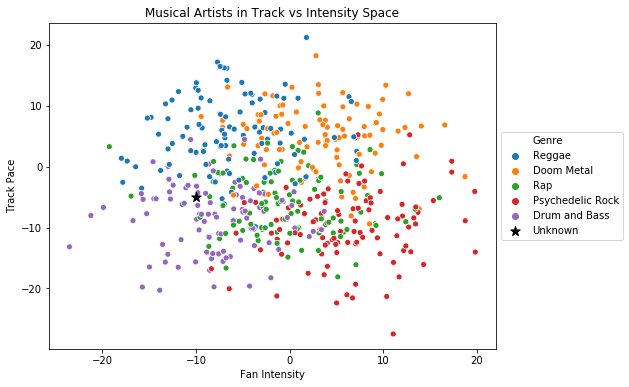

In [392]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='Fan Intensity',y='Track Pace',hue='Genre',
               data=musicData, legend='full')

plt.scatter(unknownArtist[0],unknownArtist[1],
            color='black',marker='*',s=100,label='Unknown')

plt.title('Musical Artists in Track vs Intensity Space');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Plotting the traits of the artist our friend gave us versus the other artists we are familiar with, it seems like our data suggests that the unknown artist's genre is something similar to drum and bass, rap, and/or reggae. 

How can we make a decision? Let's turn our intuition into an algorithm with some math. In particular, let's look at the distance between each point and our unknown point on this plot and check the genre of the artists that are the closest to our unknown artist. If all of the closest point are rap, for example, it would make sense that our new artist is a rapper too.

First, let's build a helper function -- a function that allows us to hide some code down the line and does a simple job for us. You may remember that the distance between two coordinates (vectors) is found by using the pythagorean theorem. 

You may also realize that this distance formula isn't restricted to 2 dimension. 

Hint: we can build this for as many descriptive dimensions as want,
such as x, y, z, a, b, c...

In [344]:
def distance(point1, point2):
    """
    Returns the Euclidean distance between two points
    
    point1: [x1,y1]
    point2: [x2,y2]
    returns: sqrt( (x1-x2)**2 + (y1-y2)**2 )
    
    >>>p1 = [0,3]
    >>>p2 = [4,0]
    >>>distance(p1,p2)
    5.0
    """
    x1,y1 = point1[0],point1[1]
    x2,y2 = point2[0],point2[1]
    
    return np.sqrt( (x1-x2)**2 + (y1-y2)**2 )

In [345]:
assert(distance([0,3],[4,0]) == 5.0)
assert(distance([0,3],[0,1]) == 2.0)

Now we have a way to define distance between different artists, and we've tested that it worked the way we think it should with testing. Since this function takes in coordinates as arguments, and the unknown artist was given to us as a coordinate, let's make a new column in the music data table called "Location" that creates a coordinate.

In [346]:
musicData['Location'] = [[musicData['Fan Intensity'][i],musicData['Track Pace'][i]] for i in musicData.index]

In [347]:
musicData.head()

,Fan Intensity,Track Pace,Genre,Location
0,-12.484366,0.339616,Reggae,"[-12.484366211276262, 0.339616282688489]"
1,-5.063562,11.700110,Doom Metal,"[-5.063562256062138, 11.700110203913388]"
2,-2.342555,-4.411273,Rap,"[-2.3425553402160975, -4.411272929674191]"
3,-11.466636,9.969344,Reggae,"[-11.4666358971729, 9.9693440645541]"
4,1.242955,0.662286,Doom Metal,"[1.2429546602272374, 0.6622861537871856]"


While the transformation into a coordinate column is not strictly necessary, it's a convenient touch for using our function from above. Let's see how we might use it on the first entry from our musicData table.

In [352]:
firstEntry = musicData[:1]
firstEntry

,Fan Intensity,Track Pace,Genre,Location
0,-12.484366,0.339616,Reggae,"[-12.484366211276262, 0.339616282688489]"


In [360]:
distance(firstEntry['Location'][0],unknownGenre)

5.889276485111155

It's now clear that the distance function works without too much effort given the location column we've built. Let's create a new column in musicData that corresponds to the distance between each location and the unknown datapoint as we've developed above.

In [361]:
musicData['Distance from Unknown Artist'] = musicData['Location'].apply(lambda loc: distance(unknownArtist,loc))
musicData.head()

,Fan Intensity,Track Pace,Genre,Location,Distance from Unknown Artist
0,-12.484366,0.339616,Reggae,"[-12.484366211276262, 0.339616282688489]",5.889276
1,-5.063562,11.700110,Doom Metal,"[-5.063562256062138, 11.700110203913388]",17.414422
2,-2.342555,-4.411273,Rap,"[-2.3425553402160975, -4.411272929674191]",7.680043
3,-11.466636,9.969344,Reggae,"[-11.4666358971729, 9.9693440645541]",15.041020
4,1.242955,0.662286,Doom Metal,"[1.2429546602272374, 0.6622861537871856]",12.588309


With considerably low effort, we've found the distances! Though this is a great triumph, we only care about the nearest points, so let's sort the table by distance in an ascending fashion.

In [363]:
sortedDistance = musicData.sort_values('Distance from Unknown Artist')
sortedDistance.head(10)

,Fan Intensity,Track Pace,Genre,Location,Distance from Unknown Artist
103,-9.267796,-4.955219,Drum and Bass,"[-9.26779609006742, -4.955218761711528]",0.733572
302,-10.325229,-4.264497,Drum and Bass,"[-10.325229443147338, -4.2644974754118135]",0.804200
207,-10.540241,-4.294454,Reggae,"[-10.540240509035215, -4.294454435376149]",0.888625
422,-10.142338,-3.923074,Drum and Bass,"[-10.142337736118172, -3.923074470334666]",1.086291
194,-9.378960,-4.045019,Drum and Bass,"[-9.378959651638684, -4.045019114340794]",1.139157
327,-8.568873,-5.020951,Drum and Bass,"[-8.568872588399627, -5.020950594349694]",1.431281
369,-10.472218,-6.376800,Drum and Bass,"[-10.472218364776092, -6.376799553345127]",1.455530
427,-11.786764,-4.832978,Drum and Bass,"[-11.786763606287202, -4.832977726579514]",1.794553
374,-11.462730,-3.912351,Drum and Bass,"[-11.46272952255974, -3.9123509750131795]",1.822789
256,-9.274883,-6.684393,Drum and Bass,"[-9.274883056688315, -6.684392597937748]",1.833841


It's now clear which artists, and thus which genres, are the closest to our unknown artist. This is where the "k" in "k nearest neighbors" comes in: how many neighbors, k, should we allow to vote on which genre our unlabeled data actually is?

We can pick a random k and see what the first k genre votes are, and maybe that will give a reasonable outcome. There may be problems with this, but let's run with it.

In [402]:
k = 5

In [403]:
sortedDistance[:k]

,Fan Intensity,Track Pace,Genre,Location,Distance from Unknown Artist
103,-9.267796,-4.955219,Drum and Bass,"[-9.26779609006742, -4.955218761711528]",0.733572
302,-10.325229,-4.264497,Drum and Bass,"[-10.325229443147338, -4.2644974754118135]",0.804200
207,-10.540241,-4.294454,Reggae,"[-10.540240509035215, -4.294454435376149]",0.888625
422,-10.142338,-3.923074,Drum and Bass,"[-10.142337736118172, -3.923074470334666]",1.086291
194,-9.378960,-4.045019,Drum and Bass,"[-9.378959651638684, -4.045019114340794]",1.139157


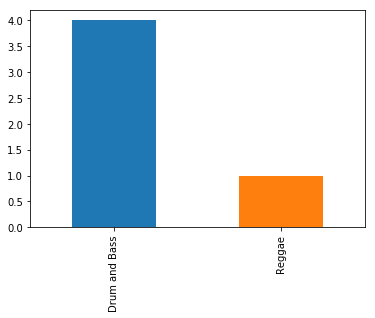

In [404]:
classVotes = sortedDistance.iloc[:k,:]['Genre'].value_counts()
classVotes.plot(kind='bar')

Picking the k at random and plotting, it looks like we got a large amount of votes for Drum and Bass, and one for Reggae. This signals that our friend's artist is indeed a Drum and Bass artist. 

Can we be 100% sure that this is the true answer? What if there is more at risk than mislabelling a genre? 

While we can't be 100% that our classification procedure did a perfect job, we can perform a *sanity check*. This means that we should look back at the data we already the labels for with some certainty, then try this procedure on those datapoints while pretending that we don't know what their label is. 

This is a critical task in machine learning, which is frequently called model validation. We care about how strongly the model performs on the data we know, and we use information available to us to make sure that our models generalizes as best as possible to the data we don't know about yet wish to make predictions about.

<>In progress<>